In [2]:
import json
import numpy as np
import networkx as nx
from collections import defaultdict, Counter
from typing import Dict, List, Tuple
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

%pip install sentence-transformers scikit-learn networkx

# For embeddings and similarity computation
try:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    print("Required libraries imported successfully!")
except ImportError as e:
    print(f"Missing library: {e}")
    print("Please install with: pip install sentence-transformers scikit-learn networkx")

np.random.seed(42)


Required libraries imported successfully!


In [3]:
import json

# Paths
base_path = r"C:\Users\julie\OneDrive\Documents\Centrale Lyon 20252026\Data science\BE2"
corpus_path = base_path + r"\corpus.jsonl"
queries_path = base_path + r"\queries.jsonl"
qrels_path = base_path + r"\valid.tsv"

# --- Load corpus ---
def load_corpus(file_path):
    """
    Load corpus data from JSONL file.
    Each line is a JSON object containing an article with key "_id".
    Returns:
        dict: {doc_id: article_data}
    """
    corpus = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            doc = json.loads(line)
            corpus[doc["_id"]] = doc
    return corpus

# --- Load queries ---
def load_queries(file_path):
    """
    Load queries data from JSONL file.
    Each line is a JSON object containing a query with key "_id".
    Returns:
        dict: {query_id: query_data}
    """
    queries = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            query = json.loads(line)
            queries[query["_id"]] = query
    return queries

# --- Load qrels ---
def load_qrels(file_path):
    """
    Load qrels from TSV file.
    Expected format: query-id \t corpus-id \t score
    Skips the header line.
    """
    qrels = {}
    with open(file_path, "r", encoding="utf-8") as f:
        next(f)  # Skip header
        for line in f:
            qid, docid, score = line.strip().split("\t")
            if qid not in qrels:
                qrels[qid] = {}
            qrels[qid][docid] = int(score)
    return qrels

# --- Load all datasets ---
print("Loading dataset...")
corpus = load_corpus(corpus_path)
queries = load_queries(queries_path)
qrels_valid = load_qrels(qrels_path)

# Affichage de la première ligne du corpus
first_corpus_id, first_corpus_doc = next(iter(corpus.items()))
print("=== Première ligne du corpus ===")
print(f"{first_corpus_id}: {first_corpus_doc}")

# Affichage de la première ligne des queries
first_query_id, first_query_text = next(iter(queries.items()))
print("\n=== Première ligne des queries ===")
print(f"{first_query_id}: {first_query_text}")

# Affichage de la première ligne des qrels
first_qrel_id, first_qrel_docs = next(iter(qrels_valid.items()))
print("\n=== Première ligne des qrels ===")
print(f"{first_qrel_id}: {first_qrel_docs}")




Loading dataset...
=== Première ligne du corpus ===
632589828c8b9fca2c3a59e97451fde8fa7d188d: {'_id': '632589828c8b9fca2c3a59e97451fde8fa7d188d', 'title': 'A hybrid of genetic algorithm and particle swarm optimization for recurrent network design', 'text': 'An evolutionary recurrent network which automates the design of recurrent neural/fuzzy networks using a new evolutionary learning algorithm is proposed in this paper. This new evolutionary learning algorithm is based on a hybrid of genetic algorithm (GA) and particle swarm optimization (PSO), and is thus called HGAPSO. In HGAPSO, individuals in a new generation are created, not only by crossover and mutation operation as in GA, but also by PSO. The concept of elite strategy is adopted in HGAPSO, where the upper-half of the best-performing individuals in a population are regarded as elites. However, instead of being reproduced directly to the next generation, these elites are first enhanced. The group constituted by the elites is reg

=== Statistiques du dataset ===
Taille du corpus : 25657 documents
Nombre de requêtes : 1000
Nombre de paires requête/document : 20950

=== Proportions de documents pertinents par requête (5 premières) ===


,positif,negatif,total,proportion_positif,proportion_negatif
40c6b953b5c04b3df4164cd487c4bc00cf0e487d,4.0,25.0,29.0,0.137931,0.862069
2dbe49d7c9a65656cd46d22ea07dc317b26482b6,5.0,25.0,30.0,0.166667,0.833333
54356ff0960100e27cf17ff682825bba2662e90c,5.0,25.0,30.0,0.166667,0.833333
f1256b20d202c73022d7a7f0151ba0010a074a06,5.0,25.0,30.0,0.166667,0.833333
8cb5835c4b4e042238304bfe7b0d96456714638a,5.0,25.0,30.0,0.166667,0.833333


Moyenne proportion de documents pertinents : 0.165
Moyenne proportion de documents non pertinents : 0.835

=== Exemple pour la requête 40c6b953b5c04b3df4164cd487c4bc00cf0e487d ===
Texte de la requête : {'_id': '40c6b953b5c04b3df4164cd487c4bc00cf0e487d', 'text': 'A Microfluidically Reconfigurable Dual-Band Slot Antenna With a Frequency Coverage Ratio of 3:1', 'metadata': {'authors': ['9515280', '31088602', '50691545', '3279966'], 'year': 2016, 'cited_by': ['20d8467d1aaca52d05a9edc34bc475de10e10d4b', '96da451c5eb8401c875ca6ee30d6235ff6880c6f', '1199e91e3ea7d4592cf40651f9aad3699d8f4733', 'b102e8ec21139df66813d480729310363b32550d'], 'references': ['462881e12a6708ddc520fa4d58c99ba73b18a6ab', '72d3f856fb0905c09ac7b6a83a9fdc9e7269eea6', 'a2e534f887c72ff3ffded55736bca4335fdb57a2', '6c84f849cefa071b1c6a9b57c322a8fba1b4fe23', 'd72928f9def3c016a55837abc6d47a73dd3d4366', '57a38a20b06f0486b40eefae245c808f5a0f3288', '9764b11a68b0305333000db0ad9f8a4d188b9572', '265c94d5de5be2f7f1a826f9e00efa1f3c21ccf

,word,value
0,algorithm,1
1,and,1
2,design,1
3,for,1
4,genetic,1
5,hybrid,1
6,network,1
7,of,1
8,optimization,1
9,particle,1



=== 20 mots les plus fréquents ===


,word,count
12584,of,8911
1149,and,8551
7259,for,8090
8947,in,5103
18107,the,4887
19810,with,2647
12648,on,2558
1977,based,2538
19116,using,2483
18306,to,2261


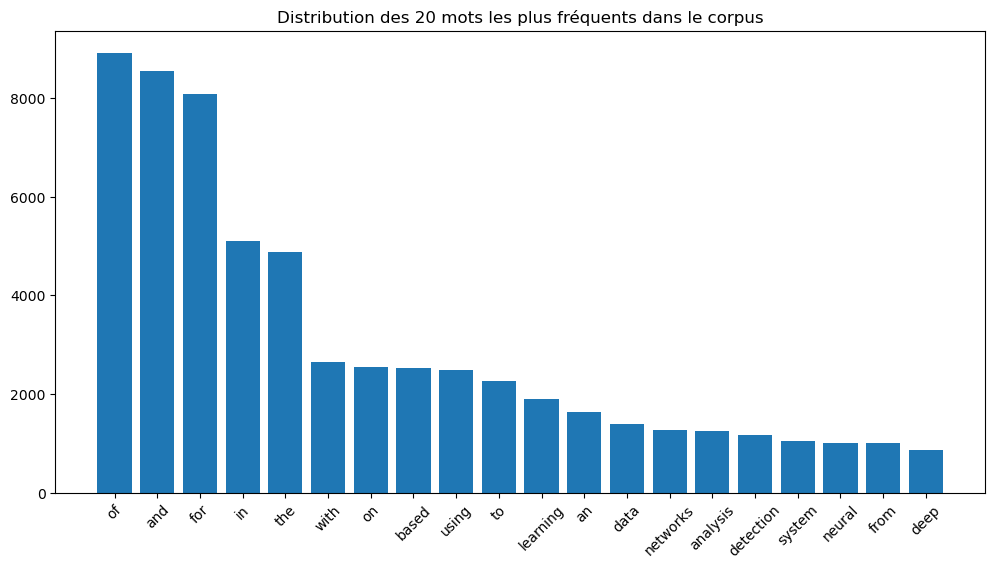

Taille vocabulaire des résumés : 76983
Dimensions matrice textes : (25657, 76983)

=== Quelques vecteurs documents avec RÉSUMÉS ===


,word,value
0,the,13
1,in,10
2,is,10
3,and,8
4,recurrent,8
5,of,7
6,elites,6
7,network,6
8,to,6
9,by,5



=== 20 mots les plus fréquents dans les résumés ===


,word,count
68233,the,245032
48847,of,162441
6838,and,137820
69129,to,103949
34698,in,89747
36854,is,56922
28033,for,50890
68204,that,42063
74234,we,40287
68592,this,36374


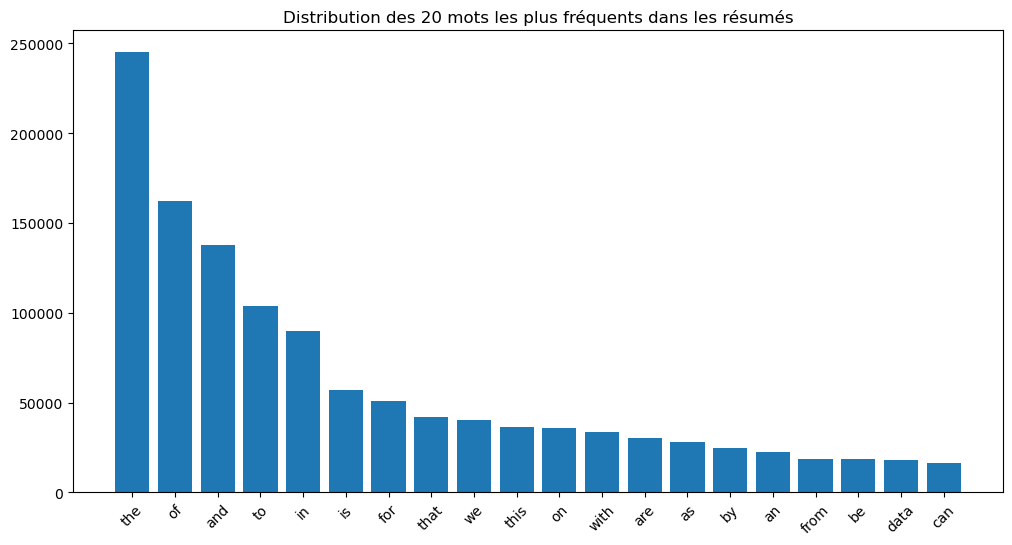

Taille vocabulaire fusionné : 78277
Dimensions matrice fusionnée (docs x termes) : (25657, 78277)


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import find
from IPython.core.display import HTML
from scipy.linalg import norm
from scipy.sparse import find, csr_matrix

# des options permettent de limiter (ou non) le nombre de lignes/colonnes affichées
# par exemple :
# pd.set_option('display.max_rows', None)

# cette fonction permet d'afficher une "jolie" représentation du vecteur v
# ARGS :
#   v : le vecteur à afficher (par ex. une ligne de la matrice X)
#   features : le vocabulaire
#   top_n : le nombre de mots maximum à afficher
def print_feats(v, features, top_n = 30):
    _, ids, values = find(v)
    feats = [(ids[i], values[i], features[ids[i]]) for i in range(len(list(ids)))]
    top_feats = sorted(feats, key=lambda x: x[1], reverse=True)[0:top_n]
    return pd.DataFrame({"word" : [t[2] for t in top_feats], "value": [t[1] for t in top_feats]})   

# fonction qui permet d'afficher plusieurs tables pandas côte à côte (c'est cadeau)
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "&emsp;"
        #output += "\xa0\xa0\xa0"
    display(HTML(output))
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import find
from IPython.core.display import HTML

# --------------------------------------------------
# 1. Statistiques simples
# --------------------------------------------------
print("=== Statistiques du dataset ===")
print(f"Taille du corpus : {len(corpus)} documents")
print(f"Nombre de requêtes : {len(queries)}")

# Nombre de paires requête/document
num_pairs = sum(len(docs) for docs in qrels_valid.values())
print(f"Nombre de paires requête/document : {num_pairs}")

# Proportions de documents pertinents et non pertinents par requête
relevance_stats = {}
for qid, docs in qrels_valid.items():
    total = len(docs)
    pos = sum(1 for s in docs.values() if s > 0)
    neg = total - pos
    relevance_stats[qid] = {"positif": pos, "negatif": neg, "total": total, 
                            "proportion_positif": pos/total, "proportion_negatif": neg/total}

relevance_df = pd.DataFrame(relevance_stats).T
print("\n=== Proportions de documents pertinents par requête (5 premières) ===")
display(relevance_df.head(5))

# Moyenne sur toutes les requêtes
mean_pos = relevance_df["proportion_positif"].mean()
mean_neg = relevance_df["proportion_negatif"].mean()
print(f"Moyenne proportion de documents pertinents : {mean_pos:.3f}")
print(f"Moyenne proportion de documents non pertinents : {mean_neg:.3f}")

# --------------------------------------------------
# 2. Exemple de requête
# --------------------------------------------------
first_qid = next(iter(qrels_valid.keys()))
print(f"\n=== Exemple pour la requête {first_qid} ===")
print("Texte de la requête :", queries[first_qid])

# Séparer candidats positifs et négatifs
pos_docs = [doc_id for doc_id, score in qrels_valid[first_qid].items() if score > 0]
neg_docs = [doc_id for doc_id, score in qrels_valid[first_qid].items() if score == 0]

print("Exemples de candidats positifs :", pos_docs[:3])
print("Exemples de candidats négatifs :", neg_docs[:3])

# --------------------------------------------------
# 3. Encodage CountVectorizer
# --------------------------------------------------
titles = [doc['title'] for doc in corpus.values()]
texts = [doc["text"] for doc in corpus.values()]

vectorizer_titles = CountVectorizer()
X_titles = vectorizer_titles.fit_transform(titles)
features_titles = vectorizer_titles.get_feature_names_out()

print(f"\nTaille de la matrice Documents x Termes : {X_titles.shape}")

# Affichage de plusieurs vecteurs avec print_feats et titres
print("\n=== Quelques vecteurs documents avec titres ===")
vectors_to_show = [0, 1, 2, 3, 4]  # indices des vecteurs à afficher
dfs = []
captions = []
doc_ids = list(corpus.keys())
for i in vectors_to_show:
    df = print_feats(X_titles[i], features_titles, top_n=10)
    dfs.append(df)
    captions.append(f"Document {i}: {corpus[doc_ids[i]]['title']}")  # ajout du titre
display_side_by_side(dfs, captions)

# --------------------------------------------------
# 4. Distribution des mots les plus fréquents
# --------------------------------------------------
word_counts = X_titles.sum(axis=0)  # somme par colonne
word_counts_array = word_counts.A1  # conversion en array plat
df_counts = pd.DataFrame({"word": features_titles, "count": word_counts_array})
df_counts_sorted = df_counts.sort_values(by="count", ascending=False).head(20)

print("\n=== 20 mots les plus fréquents ===")
display(df_counts_sorted)

plt.figure(figsize=(12,6))
plt.bar(df_counts_sorted['word'], df_counts_sorted['count'])
plt.xticks(rotation=45)
plt.title("Distribution des 20 mots les plus fréquents dans le corpus")
plt.show()


# --------------------------------------------------
# Affichage de quelques vecteurs des RÉSUMÉS
# --------------------------------------------------

# Encodage des résumés
vectorizer_texts = CountVectorizer()
X_texts = vectorizer_texts.fit_transform(texts)
features_texts = vectorizer_texts.get_feature_names_out()

print(f"Taille vocabulaire des résumés : {len(features_texts)}")
print(f"Dimensions matrice textes : {X_texts.shape}")

# --------------------------------------------------
# Affichage de quelques vecteurs des RÉSUMÉS
# --------------------------------------------------
print("\n=== Quelques vecteurs documents avec RÉSUMÉS ===")

dfs_text = []
captions_text = []

for i in vectors_to_show:  # mêmes indices que pour les titres
    df = print_feats(X_texts[i], features_texts, top_n=10)
    dfs_text.append(df)
    captions_text.append(f"Résumé Doc {i}: {corpus[doc_ids[i]]['title']}")

display_side_by_side(dfs_text, captions_text)

# --------------------------------------------------
# Distribution des mots les plus fréquents dans les résumés
# --------------------------------------------------
word_counts_text = X_texts.sum(axis=0)
word_counts_array_text = word_counts_text.A1

df_counts_text = pd.DataFrame({"word": features_texts, "count": word_counts_array_text})
df_counts_sorted_text = df_counts_text.sort_values(by="count", ascending=False).head(20)

print("\n=== 20 mots les plus fréquents dans les résumés ===")
display(df_counts_sorted_text)

plt.figure(figsize=(12,6))
plt.bar(df_counts_sorted_text['word'], df_counts_sorted_text['count'])
plt.xticks(rotation=45)
plt.title("Distribution des 20 mots les plus fréquents dans les résumés")
plt.show()

# --------------------------------------------------
# Encodage CountVectorizer : TITRE + TEXTE
# --------------------------------------------------
# Création d'un document fusionné : "titre + texte"
docs_merged = [
    (doc["title"] + " " + doc["text"]) 
    for doc in corpus.values()
]
vectorizer_merged = CountVectorizer()
X_merged = vectorizer_merged.fit_transform(docs_merged)
features_merged = vectorizer_merged.get_feature_names_out()

print(f"Taille vocabulaire fusionné : {len(features_merged)}")
print(f"Dimensions matrice fusionnée (docs x termes) : {X_merged.shape}")

In [5]:
### ==========================================================
#      5. MESURE COSINUS ENTRE DOCUMENTS
# ==========================================================
# On choisit quelques paires de documents
pairs = [(0, 3), (1, 7), (2, 5)]

print("\n=== Similarités cosinus sur TITRES ===")
for a, b in pairs:
    print("\n-------------------------------------")
    print(f"Doc {a} TITLE :", titles[a])
    print(f"Doc {b} TITLE :", titles[b])

    sim = cosine_similarity(X_titles[a], X_titles[b])[0][0]
    print(f"Similarité cosinus = {sim:.4f}")

# --------------------------------------------------
# Similarité cosinus entre résumés
# --------------------------------------------------

print("\n===================================================")
print("     SIMILARITÉ COSINUS SUR LES RÉSUMÉS (text)")
print("===================================================\n")

pairs = [(0, 3), (1, 7), (2, 5)]  # mêmes paires qu'avant

for a, b in pairs:
    print("\n-------------------------------------")
    print(f"Doc {a} TEXT (début) :\n", texts[a][:300], "...")
    print(f"\nDoc {b} TEXT (début) :\n", texts[b][:300], "...\n")

    sim_text = cosine_similarity(X_texts[a], X_texts[b])[0][0]
    print(f"Similarité cosinus entre résumés = {sim_text:.4f}")

# ==========================================================
#           6. MOTEUR DE RECHERCHE SIMPLE
# ==========================================================
# ==========================================================
#           MOTEUR DE RECHERCHE AMÉLIORÉ
# ==========================================================
def search(query, vectorizer, X, corpus, top_k=10, field="merged"):
    """
    Petit moteur de recherche basé sur la similarité cosinus.
    
    Args:
        query (str): texte de la requête
        vectorizer: CountVectorizer (ou TfidfVectorizer) déjà fit sur X
        X (sparse matrix): matrice documents x termes
        corpus (dict): dictionnaire des documents
        top_k (int): nombre de résultats à retourner
        field (str): "title", "text", ou "merged" pour choisir le champ à afficher
    
    Returns:
        list of dict: doc_id, score, title, text
    """
    q_vec = vectorizer.transform([query])
    scores = cosine_similarity(q_vec, X)[0]
    top_idx = np.argsort(scores)[::-1][:top_k]
    
    results = []
    ids = list(corpus.keys())
    
    for idx in top_idx:
        doc = corpus[ids[idx]]
        
        if field == "title":
            content = doc["title"]
        elif field == "text":
            content = doc["text"]
        else:
            content = doc["title"] + " " + doc["text"]
        
        # Limiter le texte pour affichage
        preview = content[:300] + "..." if len(content) > 300 else content
        
        results.append({
            "doc_id": ids[idx],
            "score": scores[idx],
            "title": doc["title"],
            "preview": preview
        })
    return results

# ==========================================================
#           TEST DU MOTEUR
# ==========================================================
query = "machine learning medical diagnosis"

print("\n=== Résultats sur TITRE+TEXTE ===")
results = search(query, vectorizer_merged, X_merged, corpus, top_k=10, field="merged")
for r in results:
    print(f"[{r['score']:.4f}] {r['title']}\nPreview: {r['preview']}\n")

print("\n=== Résultats sur TITRE seulement ===")
results = search(query, vectorizer_titles, X_titles, corpus, top_k=10, field="title")
for r in results:
    print(f"[{r['score']:.4f}] {r['title']}\nPreview: {r['preview']}\n")

print("\n=== Résultats sur RÉSUMÉ seulement ===")
results = search(query, vectorizer_texts, X_texts, corpus, top_k=10, field="text")
for r in results:
    print(f"[{r['score']:.4f}] {r['title']}\nPreview: {r['preview']}\n")


# ==========================================================
#           Reste à faire: Modifier les paramètres du "vectoriseur" : taille du vocabulaire, suppression des mots-outils, suppression des mots trop rares ou trop fréquents, stemming
#           Utiliser une autre pondération, comme TFxIDF
# ==========================================================


=== Similarités cosinus sur TITRES ===

-------------------------------------
Doc 0 TITLE : A hybrid of genetic algorithm and particle swarm optimization for recurrent network design
Doc 3 TITLE : A modified particle swarm optimizer
Similarité cosinus = 0.2887

-------------------------------------
Doc 1 TITLE : A Hybrid EP and SQP for Dynamic Economic Dispatch with Nonsmooth Fuel Cost Function
Doc 7 TITLE : A data mining approach for location prediction in mobile environments
Similarité cosinus = 0.0925

-------------------------------------
Doc 2 TITLE : Genetic Fuzzy Systems - Evolutionary Tuning and Learning of Fuzzy Knowledge Bases
Doc 5 TITLE : Separate face and body selectivity on the fusiform gyrus.
Similarité cosinus = 0.0925

     SIMILARITÉ COSINUS SUR LES RÉSUMÉS (text)


-------------------------------------
Doc 0 TEXT (début) :
 An evolutionary recurrent network which automates the design of recurrent neural/fuzzy networks using a new evolutionary learning algorithm is p

In [6]:
# ==========================================================
#           7. Mesure AUC globale (Sparse)
# ==========================================================
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

print("\n===== ÉVALUATION SPARSE — AUC SEULEMENT =====")

all_doc_ids = list(corpus.keys())
auc_list = []

for qid, cand_map in qrels_valid.items():

    # Vérifier que la query existe
    if qid not in queries:
        continue

    query_text = queries[qid]["text"]

    # Ids candidats de valid.tsv
    candidate_ids = [d for d in cand_map.keys() if d in corpus]
    if len(candidate_ids) < 2:
        continue  # impossible de faire AUC

    # Construire matrice des candidats
    cand_idx = [all_doc_ids.index(d) for d in candidate_ids]
    cand_vectors = X_merged[cand_idx]                      
    q_vec = vectorizer_merged.transform([query_text])    

    # scores + labels
    scores = cosine_similarity(q_vec, cand_vectors)[0]
    labels = [int(cand_map[d]) for d in candidate_ids]

    # calcul AUC pour cette query
    if len(set(labels)) > 1:  # faut au moins un positif et un négatif
        auc_list.append( roc_auc_score(labels, scores) )

# === Score final
if len(auc_list) > 0:
    print(f" AUC moyen sur valid.tsv = {np.mean(auc_list):.4f}")
else:
    print("⚠ Impossible de calculer l'AUC (pas assez de labels variés)")



===== ÉVALUATION SPARSE — AUC SEULEMENT =====
 AUC moyen sur valid.tsv = 0.7504


In [7]:
# ==========================================================
# 7. ENCODAGE AVEC SENTENCE-TRANSFORMERS
# ==========================================================
from sentence_transformers import SentenceTransformer
import numpy as np
import os
import pickle

# Choix du modèle
model_name = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

# Chemin pour sauvegarder les embeddings
embeddings_file = r"C:\Users\julie\OneDrive\Documents\Centrale Lyon 20252026\Data science\BE2\corpus_embeddings.pkl"


# On crée la liste des documents à encoder : titre + texte
docs_merged = [doc["title"] + " " + doc["text"] for doc in corpus.values()]

# Vérifier si les embeddings existent déjà
if os.path.exists(embeddings_file):
    print("Chargement des embeddings depuis le fichier...")
    with open(embeddings_file, "rb") as f:
         corpus_embeddings = pickle.load(f)
else:
    print("Encodage des documents avec SentenceTransformer, cela peut prendre quelques minutes...")
    corpus_embeddings = model.encode(docs_merged, show_progress_bar=True, convert_to_numpy=True)
    # Sauvegarde des embeddings
    with open(embeddings_file, "wb") as f:
        pickle.dump( corpus_embeddings, f)
    print(f"Embeddings sauvegardés dans {embeddings_file}")

print("Dimensions des embeddings :",  corpus_embeddings.shape)

# ==========================================================
# 8. MOTEUR DE RECHERCHE AVEC EMBEDDINGS (TEST)
# ==========================================================
def search_embeddings(query, model, embeddings, corpus, top_k=10):
    """
    Petit moteur de recherche basé sur les embeddings et la similarité cosinus.
    
    Args:
        query (str): texte de la requête
        model (SentenceTransformer): modèle pour encoder la requête
        embeddings (np.array): matrice embeddings du corpus
        corpus (dict): dictionnaire des documents
        top_k (int): nombre de résultats à retourner
    
    Returns:
        list of dict: doc_id, score, title, preview
    """
    # Encoder la requête
    q_vec = model.encode([query], convert_to_numpy=True)
    
    # Cosine similarity
    scores = (embeddings @ q_vec.T).squeeze() / (np.linalg.norm(embeddings, axis=1) * np.linalg.norm(q_vec))
    
    # Trier par score décroissant
    top_idx = np.argsort(scores)[::-1][:top_k]
    
    # Construire les résultats
    results = []
    doc_ids = list(corpus.keys())
    for idx in top_idx:
        results.append({
            "doc_id": doc_ids[idx],
            "score": scores[idx],
            "title": corpus[doc_ids[idx]]["title"],
            "preview": corpus[doc_ids[idx]]["text"][:300] + "..."
        })
    return results

# Test moteur de recherche
query = "machine learning medical diagnosis"
results = search_embeddings(query, model, corpus_embeddings, corpus, top_k=10)

print("\n=== Résultats avec Sentence-Transformers (titre + texte fusionnés) ===")
for r in results:
    print(f"[{r['score']:.4f}] {r['title']}\nPreview: {r['preview']}\n")


Chargement des embeddings depuis le fichier...
Dimensions des embeddings : (25657, 384)

=== Résultats avec Sentence-Transformers (titre + texte fusionnés) ===
[0.6841] Machine Learning in Medical Applications
Preview: Research in Machine Learning methods to-date remains centered on technological issues and is mostly application driven. This letter summarizes successful applications of machine learning methods that were presented at the Workshop on Machine Learning in Medical Applications. The goals of the worksho...

[0.6370] Analysing and improving the diagnosis of ischaemic heart disease with machine learning
Preview: Ischaemic heart disease is one of the world's most important causes of mortality, so improvements and rationalization of diagnostic procedures would be very useful. The four diagnostic levels consist of evaluation of signs and symptoms of the disease and ECG (electrocardiogram) at rest, sequential E...

[0.6288] Selected techniques for data mining in medicine
Preview: 

In [8]:
# ============================
# 5. Nouveau moteur de recherche (dense) + évaluation
# ============================
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import warnings

# --- paramètres ---
TOP_K_RETURN = 25   # on retourne / trie parmi les 25 premiers candidats demandés
TOP_K_CHECK = 5     # on vérifie si les 5 premiers sont pertinents (consigne)
PRINT_EXAMPLES = 5  # afficher résultats pour les 5 premières requêtes de valid.tsv

# Préparer une liste ordonnée d'ids du corpus (stable)
all_doc_ids = list(corpus.keys())

def dense_search_among_candidates(query_text, model, corpus_embeddings, corpus, candidate_ids, top_k_return=25):
    """
    Encode la query (texte), calcule la similarité cosinus entre la query et les candidats
    (seulement ceux présents dans le corpus), et retourne la liste triée des candidats
    avec leurs scores (top_k_return résultats maximum).
    - candidate_ids : liste d'ids issus de valid.tsv (environ 25-30)
    """
    # Filtrer candidats présents dans le corpus et construire embeddings correspondants
    cand_ids_in_corpus = []
    cand_embeddings = []
    for did in candidate_ids:
        if did in corpus:
            idx = all_doc_ids.index(did)
            cand_embeddings.append(corpus_embeddings[idx])
            cand_ids_in_corpus.append(did)
        else:
            # si absent, on l'ignore (on pourrait encoder son texte s'il était disponible)
            warnings.warn(f"Candidate {did} absent du corpus -> ignored")
    if len(cand_ids_in_corpus) == 0:
        return []  # aucun candidat disponible

    cand_embeddings = np.vstack(cand_embeddings)  # shape (n_cand_available, dim)

    # Encoder la requête
    q_vec = model.encode([query_text], convert_to_numpy=True)

    # Calculer similarité cosinus entre la requête et chacun des candidats disponibles
    scores = cosine_similarity(q_vec, cand_embeddings)[0]  # (n_cand_available,)

    # Trier et prendre top_k_return
    order = np.argsort(scores)[::-1]
    order = order[:top_k_return]

    results = []
    for i in order:
        did = cand_ids_in_corpus[i]
        results.append({
            "doc_id": did,
            "score": float(scores[i]),
            "title": corpus[did]["title"],
            "preview": corpus[did]["text"][:300] + "..."
        })
    return results

# --------------------
# 1) Tester sur quelques requêtes (5 premières de valid.tsv) et afficher top-5
# --------------------
print("\n=== EXEMPLES : Affichage top-5 pour 5 premières requêtes dans valid.tsv ===")
example_qids = list(qrels_valid.keys())[:PRINT_EXAMPLES]
for qid in example_qids:
    # s'assurer que la query existe dans queries
    if qid not in queries:
        print(f"QID {qid} absent de queries -> skip")
        continue
    query_text = queries[qid].get("text", "")
    candidate_ids = list(qrels_valid[qid].keys())

    results = dense_search_among_candidates(query_text, model, corpus_embeddings, corpus, candidate_ids, top_k_return=TOP_K_RETURN)
    print("\n" + "="*70)
    print(f"Query id: {qid}")
    print("Query text:", query_text)
    print(f"Top-{TOP_K_CHECK} predictions (doc_id | score | label in valid.tsv):")
    for r in results[:TOP_K_CHECK]:
        label = qrels_valid[qid].get(r["doc_id"], 0)
        print(f" - {r['doc_id']} | {r['score']:.4f} | label={label} | title: {r['title']}")
    print("="*70)

# --------------------
# 2) Évaluation sur toutes les requêtes présentes dans valid.tsv
#    - Pour chaque requête, on trie les candidats fournis (valid.tsv) et récupère top-K (ici TOP_K_CHECK)
#    - On calcule TP = nombre de top-K qui ont label==1 dans valid.tsv
#    - On agrège micro et macro P@5, R@5, F1@5
#    - On calcule AUC par requête (sur tous les candidats disponibles) et on prend la moyenne des AUC valides
# --------------------
per_query_metrics = []
sum_TP = 0
sum_retrieved = 0
sum_positives = 0
auc_list = []

for qid, cand_map in qrels_valid.items():
    # ne traiter que si la query existe dans queries
    if qid not in queries:
        continue
    query_text = queries[qid].get("text", "")
    candidate_ids = list(cand_map.keys())  # ~25-30 ids

    # Récupérer résultats triés parmi candidats
    results = dense_search_among_candidates(query_text, model, corpus_embeddings, corpus, candidate_ids, top_k_return=TOP_K_RETURN)
    if len(results) == 0:
        # pas de candidats valides dans le corpus -> on skip
        continue

    # Top-K predicted (pour métriques demandées)
    topk_results = results[:TOP_K_CHECK]
    topk_doc_ids = [r["doc_id"] for r in topk_results]

    # true labels for ALL candidates (from valid.tsv). 
    # For AUC we use only candidates present in corpus (we computed scores there)
    # Build arrays aligned with candidate_ids actually present in corpus
    cand_ids_in_corpus = [did for did in candidate_ids if did in corpus]
    if len(cand_ids_in_corpus) == 0:
        continue
    cand_embeddings = np.vstack([corpus_embeddings[all_doc_ids.index(d)] for d in cand_ids_in_corpus])
    cand_scores = cosine_similarity(model.encode([query_text], convert_to_numpy=True), cand_embeddings)[0]
    cand_labels = [int(cand_map.get(did, 0)) for did in cand_ids_in_corpus]

    # AUC per query (only if there is at least one positive and one negative among available)
    try:
        if len(set(cand_labels)) > 1:
            auc_q = roc_auc_score(cand_labels, cand_scores)
            auc_list.append(auc_q)
        else:
            auc_q = None
    except Exception as e:
        auc_q = None

    # compute TP for top-K (using labels from valid.tsv; if a top doc is absent from valid.tsv label default 0)
    tp = sum(1 for did in topk_doc_ids if int(cand_map.get(did, 0)) == 1)
    retrieved = len(topk_doc_ids)  # ideally = TOP_K_CHECK
    positives_total = sum(int(v) for v in cand_map.values())  # should be 5 by construction

    # per-query metrics P@K, R@K, F1@K (recall calculated vs total positives in valid.tsv)
    prec_q = tp / retrieved if retrieved > 0 else 0.0
    rec_q = tp / positives_total if positives_total > 0 else 0.0
    f1_q = (2 * prec_q * rec_q / (prec_q + rec_q)) if (prec_q + rec_q) > 0 else 0.0

    per_query_metrics.append({
        "qid": qid,
        "tp": tp,
        "retrieved": retrieved,
        "positives_total": positives_total,
        "precision_at_k": prec_q,
        "recall_at_k": rec_q,
        "f1_at_k": f1_q,
        "auc": auc_q
    })

    sum_TP += tp
    sum_retrieved += retrieved
    sum_positives += positives_total

# Agrégation
if len(per_query_metrics) == 0:
    raise RuntimeError("Aucune requête évaluée : vérifie que qrels_valid contient des requêtes et que queries correspond.")

# Macro-average (moyenne simple des métriques par requête)
macro_precision = np.mean([m["precision_at_k"] for m in per_query_metrics])
macro_recall = np.mean([m["recall_at_k"] for m in per_query_metrics])
macro_f1 = np.mean([m["f1_at_k"] for m in per_query_metrics])
macro_auc = np.mean([m["auc"] for m in per_query_metrics if m["auc"] is not None]) if any(m["auc"] is not None for m in per_query_metrics) else None

# Micro-average (global sums)
micro_precision = sum_TP / sum_retrieved if sum_retrieved > 0 else 0.0
micro_recall = sum_TP / sum_positives if sum_positives > 0 else 0.0
micro_f1 = (2 * micro_precision * micro_recall / (micro_precision + micro_recall)) if (micro_precision + micro_recall) > 0 else 0.0

# Affichage des résultats
print("\n=== ÉVALUATION GLOBALE (sur toutes les requêtes de valid.tsv présentes) ===")
print(f"Nombre de requêtes évaluées: {len(per_query_metrics)}")
print(f"Macro P@{TOP_K_CHECK}: {macro_precision:.4f}")
print(f"Macro R@{TOP_K_CHECK}: {macro_recall:.4f}")
print(f"Macro F1@{TOP_K_CHECK}: {macro_f1:.4f}")
print(f"Micro P@{TOP_K_CHECK}: {micro_precision:.4f}")
print(f"Micro R@{TOP_K_CHECK}: {micro_recall:.4f}")
print(f"Micro F1@{TOP_K_CHECK}: {micro_f1:.4f}")
if macro_auc is not None:
    print(f"Macro AUC (moyenne des AUC par requête): {macro_auc:.4f}")
else:
    print("Macro AUC: non disponible (aucune AUC valide calculable)")



=== EXEMPLES : Affichage top-5 pour 5 premières requêtes dans valid.tsv ===

Query id: 40c6b953b5c04b3df4164cd487c4bc00cf0e487d
Query text: A Microfluidically Reconfigurable Dual-Band Slot Antenna With a Frequency Coverage Ratio of 3:1
Top-5 predictions (doc_id | score | label in valid.tsv):
 - d59814a5014f220c1bd43fef6393b1250ecdc58b | 0.5915 | label=1 | title: A Coplanar Reconfigurable Folded Slot Antenna Without Bias Network for WLAN Applications
 - 462881e12a6708ddc520fa4d58c99ba73b18a6ab | 0.3804 | label=1 | title: Continuous Electrowetting of Non-toxic Liquid Metal for RF Applications
 - 89c1c6c952e1e962677026269c094b8c0a966ee0 | 0.3350 | label=1 | title: A Low-Profile Third-Order Bandpass Frequency Selective Surface
 - 1614efe6116dd83073ed4c99b0da61e9a111a69f | 0.1037 | label=0 | title: Using ultra-low parasitic hybrid packaging method to reduce high frequency EMI noise for SiC power module
 - 4a20823dd4ce6003e31f7d4e0649fe8c719926f2 | 0.1028 | label=0 | title: A gene-coexpress

In [14]:
# ============================
# 10. PRÉDICTION AVEC COSINE_SIMILARITY (FIX ORDER)
# ============================
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

sample_path  = base_path + r"\sample_submission.csv"
output_file  = base_path + r"\sample_submission_final.csv"

print("\n=== Chargement du sample_submission.csv ===")
df = pd.read_csv(sample_path, sep=",", dtype=str)

# mapping document_id → index des embeddings (cohérent avec corpus_embeddings)
doc_index = {doc_id: i for i, doc_id in enumerate(corpus.keys())}

# IMPORTANT : on crée la colonne score et on remplira par index (pour garder l'ordre exact)
df["score"] = np.nan

print("\nCalcul cosine_similarity pour toutes les paires query-document (ordre préservé)...")

# sort=False évite que groupby trie les query-id et casse l’alignement
for qid, group in df.groupby("query-id", sort=False):

    rows_idx = group.index

    # cas où la query n’existe pas → tout = 0
    if qid not in queries:
        df.loc[rows_idx, "score"] = 0.0
        continue

    # embed de la query (une seule fois par groupe)
    q_vec = model.encode([queries[qid]["text"]], convert_to_numpy=True)

    # scores de ce groupe, dans le même ordre que les lignes group (donc rows_idx)
    scores = []
    for docid in group["corpus-id"].tolist():
        i = doc_index.get(docid, None)

        if i is None:   # document pas dans corpus
            scores.append(0.0)
        else:
            doc_vec = corpus_embeddings[i].reshape(1, -1)
            sim = cosine_similarity(q_vec, doc_vec)[0, 0]
            scores.append(float(sim))

    # réinjection sur les BONNES lignes (préserve l’ordre du fichier)
    df.loc[rows_idx, "score"] = scores

# sécurité : aucun NaN
df["score"] = df["score"].fillna(0.0).astype(float)

# Sauvegarde finale
df.to_csv(output_file, sep=",", index=False)

print(f"\n✅ Cosine similarity exporté dans : {output_file}")
print("⚠ Score = vraie similarité cosinus, correctement alignée avec chaque ligne")



=== Chargement du sample_submission.csv ===

Calcul cosine_similarity pour toutes les paires query-document (ordre préservé)...

✅ Cosine similarity exporté dans : C:\Users\julie\OneDrive\Documents\Centrale Lyon 20252026\Data science\BE2\sample_submission_final.csv
⚠ Score = vraie similarité cosinus, correctement alignée avec chaque ligne



=== 6) Analyse thématique avec LDA sur le corpus ===
📄 Documents chargés : 25657
 Vocabulaire retenu : 12302 tokens

 Modèle détecté → chargement : C:\Users\julie\OneDrive\Documents\Centrale Lyon 20252026\Data science\BE2\lda_model_30.mdl

===  Principaux Topics ===
(0, '0.046*"network" + 0.032*"networks" + 0.021*"communication" + 0.019*"wireless" + 0.017*"energy" + 0.014*"traffic" + 0.013*"nodes" + 0.012*"channel" + 0.010*"multiple" + 0.009*"protocol"')
(1, '0.048*"cell" + 0.048*"cells" + 0.034*"expression" + 0.023*"gene" + 0.019*"ii" + 0.018*"plant" + 0.015*"iii" + 0.015*"growth" + 0.013*"ecg" + 0.011*"plants"')
(2, '0.047*"recognition" + 0.022*"speech" + 0.018*"features" + 0.017*"text" + 0.015*"system" + 0.013*"using" + 0.012*"sentiment" + 0.011*"based" + 0.010*"identification" + 0.009*"dataset"')
(3, '0.024*"graphs" + 0.023*"university" + 0.019*"use" + 0.017*"science" + 0.016*"de" + 0.014*"research" + 0.013*"http" + 0.012*"author" + 0.011*"computer" + 0.010*"book"')
(4, '0.015*"ma

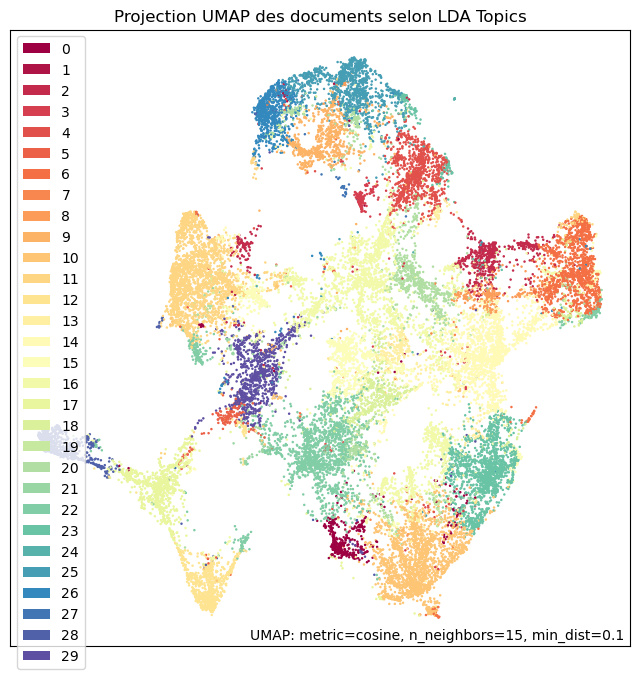

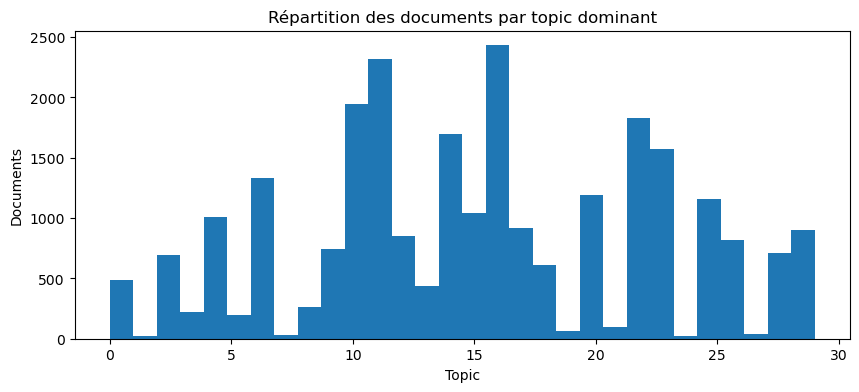


=== FIN SECTION 6 — LDA + UMAP OK ===

 Génération PyLDAvis...



 Visualisation affichée


In [10]:
# ==========================================================
# 6. ANALYSE THÉMATIQUE SIMPLE AVEC LDA (modèle stocké avec StopWords)
# ==========================================================
import warnings
warnings.filterwarnings('ignore')
import os
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
import numpy as np
import pandas as pd
from umap.umap_ import UMAP
import umap.plot
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import matutils

print("\n=== 6) Analyse thématique avec LDA sur le corpus ===")

# ---------------------------------------------------------------------
#  Dossier principal = même chemin que STOP WORDS
# ---------------------------------------------------------------------
lda_dir = r"C:\Users\julie\OneDrive\Documents\Centrale Lyon 20252026\Data science\BE2"
stopwords_path = os.path.join(lda_dir, "Stop-words-en.txt")

# vérif existence
if not os.path.exists(stopwords_path):
    raise FileNotFoundError("⚠ Le fichier Stop-words-en.txt est introuvable !")

# ---------------------------------------------------------------------
# 1) Extraction corpus texte
# ---------------------------------------------------------------------
docs = [doc["title"] + " " + doc["text"] for doc in corpus.values()]
ndocs = len(docs)
print(f"📄 Documents chargés : {ndocs}")

# ---------------------------------------------------------------------
# 2) Prétraitement (tokenization + nettoyage)
# ---------------------------------------------------------------------
def sent_to_words(sentences):
    for s in sentences:
        yield simple_preprocess(str(s), deacc=True)

data_words = list(sent_to_words(docs))

# --- Stopwords ---
with open(stopwords_path) as f:
    stopwords = [w.strip() for w in f.readlines()]

def remove_stopwords(texts):
    return [[w for w in doc if w not in stopwords] for doc in texts]

data_words_nostops = remove_stopwords(data_words)

# ---------------------------------------------------------------------
# 3) Construction LDA
# ---------------------------------------------------------------------
dico = corpora.Dictionary(data_words_nostops)
dico.filter_extremes(no_below=10, no_above=0.5)

corpus_bow = [dico.doc2bow(text) for text in data_words_nostops]
print(f" Vocabulaire retenu : {len(dico)} tokens")

ntopics = 30
model_path = os.path.join(lda_dir, f"lda_model_{ntopics}.mdl")

#  Auto-SAVE/LOAD
if os.path.exists(model_path):
    print(f"\n Modèle détecté → chargement : {model_path}")
    ldamodel = LdaModel.load(model_path)
else:
    print(f"\n Aucun modèle trouvé → entraînement d'un LDA ({ntopics} topics)...")
    ldamodel = LdaModel(corpus=corpus_bow, num_topics=ntopics, id2word=dico,
                        passes=30, random_state=42)
    ldamodel.save(model_path)
    print(f" Modèle sauvegardé ici → {model_path}")

# ---------------------------------------------------------------------
# Affichage des Topics
# ---------------------------------------------------------------------
print("\n===  Principaux Topics ===")
for topic in ldamodel.show_topics(num_topics=ntopics, formatted=True):
    print(topic)

# ---------------------------------------------------------------------
# 4) Matrice p(topic|document)
# ---------------------------------------------------------------------
doc_vec = np.zeros((ndocs, ntopics))

for i, bow in enumerate(corpus_bow):
    for topic, weight in ldamodel.get_document_topics(bow):
        doc_vec[i, topic] = weight

dominant_topic = np.argmax(doc_vec, axis=1)

df_topics = pd.DataFrame({
    "doc_id": list(corpus.keys()),
    "topic_dominant": dominant_topic
})
df_topics.to_csv(os.path.join(lda_dir, "topics_by_document.csv"), index=False)
print("\n📄 Export → topics_by_document.csv")

# ---------------------------------------------------------------------
# 5) UMAP : Visualisation des clusters de topics
# ---------------------------------------------------------------------
print("\n UMAP clustering...")
mapper = UMAP(metric="cosine", n_neighbors=15, min_dist=0.1).fit(doc_vec)
umap.plot.points(mapper, labels=dominant_topic)

plt.title("Projection UMAP des documents selon LDA Topics")
plt.show()

plt.figure(figsize=(10,4))
plt.hist(dominant_topic, bins=ntopics)
plt.title("Répartition des documents par topic dominant")
plt.xlabel("Topic")
plt.ylabel("Documents")
plt.show()

print("\n=== FIN SECTION 6 — LDA + UMAP OK ===")

# =========================================================
#  7. Analyse interactive des thèmes avec PyLDAvis
# =========================================================
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import matutils
from IPython.display import HTML, display

print("\n Génération PyLDAvis...")

corpus_csc = matutils.corpus2csc(corpus_bow)
lda_vis = gensimvis.prepare(ldamodel, corpus_csc, dico)

#  affichage enfin opérationnel
html_vis = HTML(pyLDAvis.prepared_data_to_html(lda_vis))
display(html_vis)                         # <<< indispensable pour rendre l’output !
print(f"\n Visualisation affichée")

# AMELIORATION POTENTIELLE: choisir un nombre optimal de topics


==============  Construction du graphe de citations  ==============

 Nombre de documents (nœuds) : 25657
 Nombre total d'arcs uniques : 54270
 Densité du graphe          : 0.0000824451
⚠ Références manquantes = 197491  |  Citers manquants = 4761050

 Visualisation sur les 500 nœuds ayant le plus haut degree...


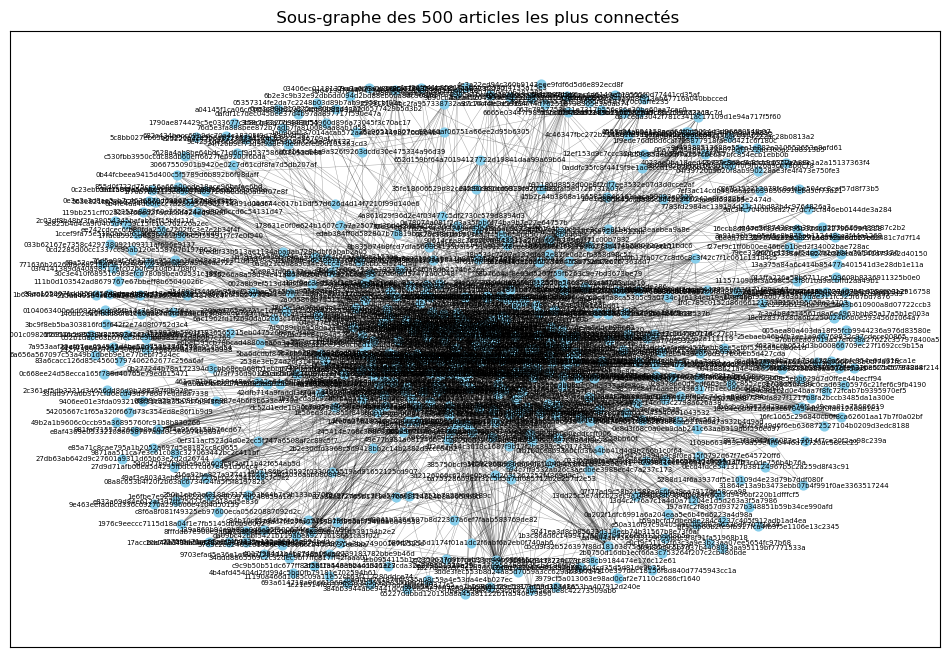

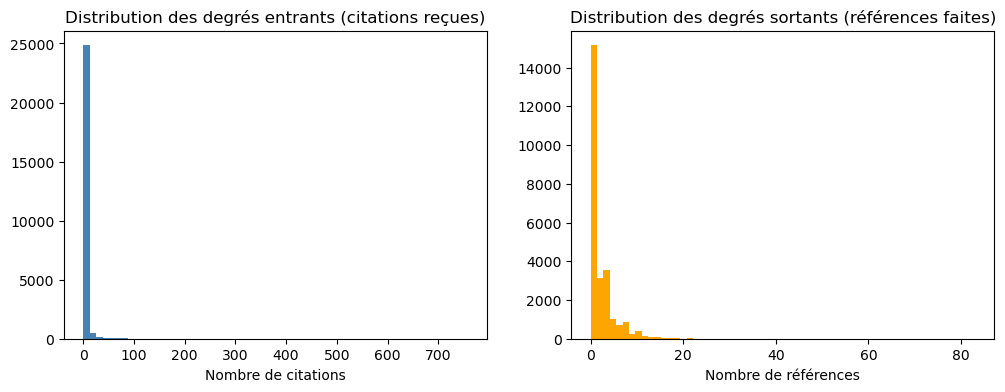


 Moyenne IN  : 2.1152   | Variance : 140.0274
 Moyenne OUT : 2.1152 | Variance : 10.3763

 Matrice d'adjacence du sous-graphe (500 nœuds)


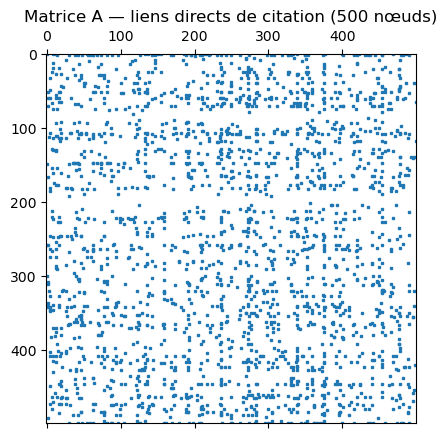

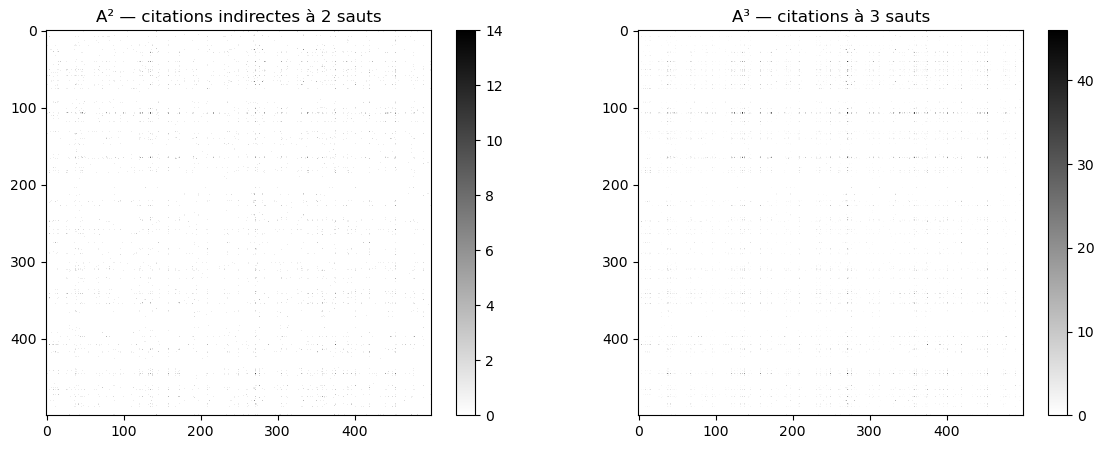


==============  Calcul des centralités =================



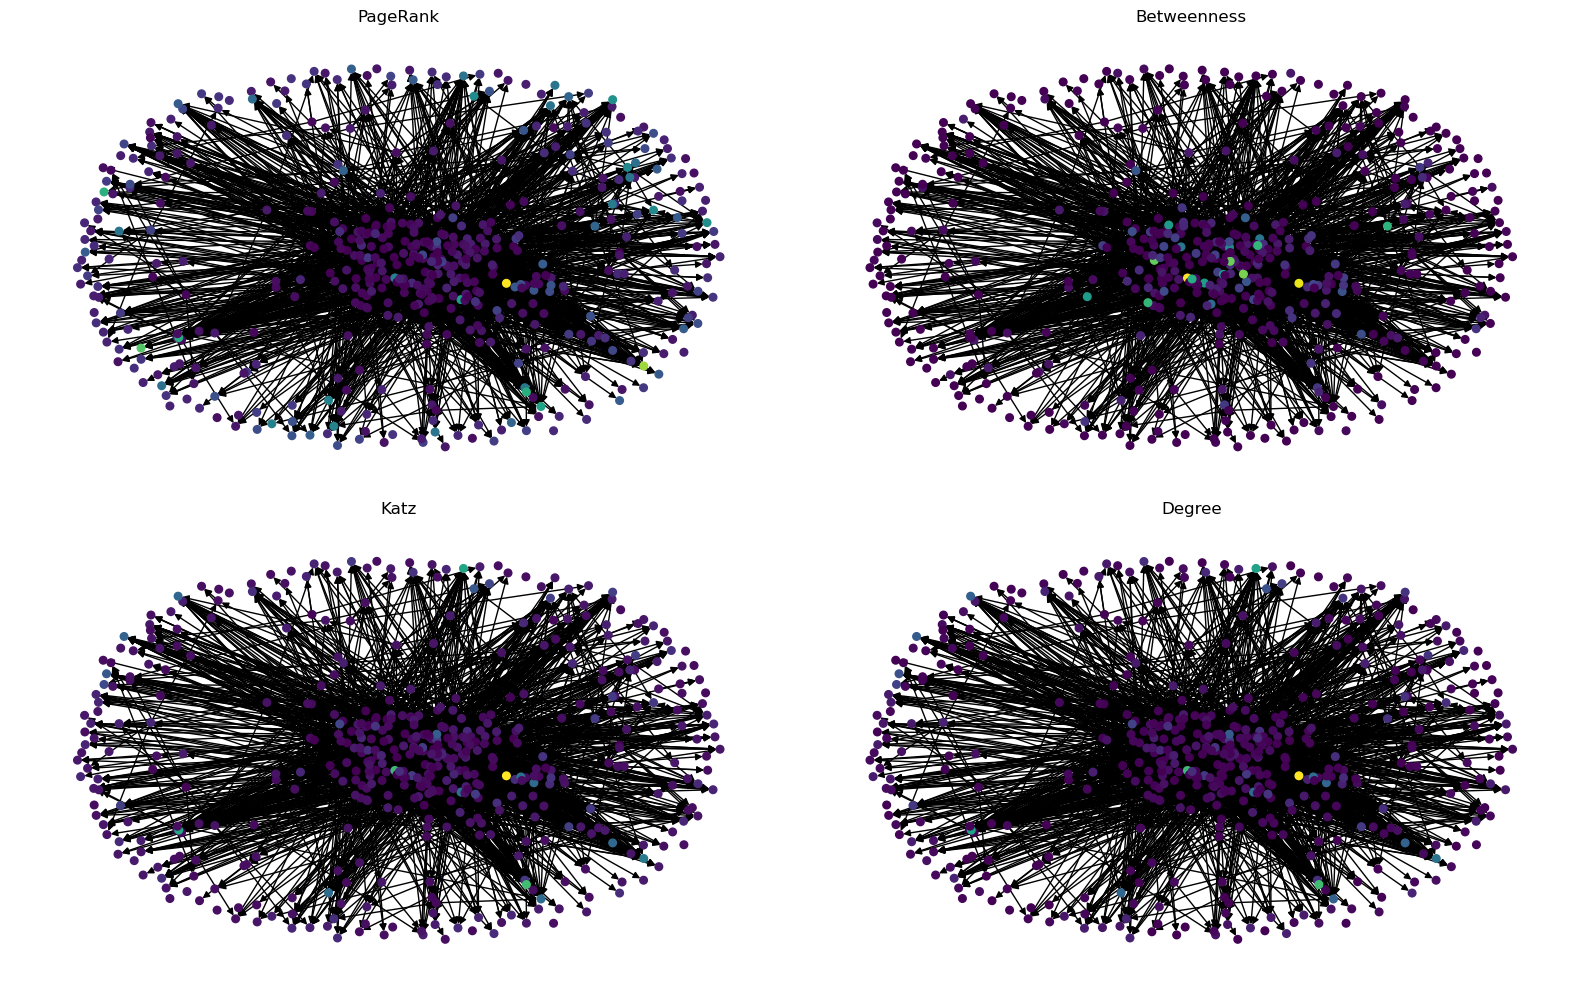


 Top 10 PageRank :
 2315fc6c2c0c4abd2443e26a26e7bb86df8e24cc (0.0036) — ImageNet Classification with Deep Convolutional Neural Networks
 cbcd9f32b526397f88d18163875d04255e72137f (0.0031) — Gradient-based learning applied to document recognition
 4eb943bf999ce49e5ebb629d7d0ffee44becff94 (0.0027) — Finding Structure in Time
 0541d5338adc48276b3b8cd3a141d799e2d40150 (0.0023) — MapReduce: Simplified Data Processing on Large Clusters
 272216c1f097706721096669d85b2843c23fa77d (0.0023) — Adam: A Method for Stochastic Optimization
 0b3cfbf79d50dae4a16584533227bb728e3522aa (0.0023) — Long Short-Term Memory
 54dd77bd7b904a6a69609c9f3af11b42f654ab5d (0.0021) — ImageNet: A large-scale hierarchical image database
 7752e0835506a6629c1b06e67f2afb1e5d2bb714 (0.0021) — Convergent and discriminant validation by the multitrait-multimethod matrix.
 1e56ed3d2c855f848ffd91baa90f661772a279e1 (0.0021) — Latent Dirichlet Allocation
 213d7af7107fa4921eb0adea82c9f711fd105232 (0.0018) — Reducing the dimensionali

In [11]:
# ================================================================
# === 7) Graphe de citations complet + analyse inspirée du cours ==
# ================================================================

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse

print("\n==============  Construction du graphe de citations  ==============")

edges = set()                 # évite les doublons
missing_refs = 0
missing_citers = 0

for doc_id, doc in corpus.items():

    # ==================================================
    # 🔹 Degré sortant = documents cités par ce papier
    # ==================================================
    for ref in doc.get("metadata", {}).get("references", []):
        if ref in corpus and ref != doc_id:
            edges.add((doc_id, ref))   # doc → ref
        else:
            missing_refs += 1

    # ==================================================
    # 🔹 Degré entrant = documents qui le citent
    # ==================================================
    for citer in doc.get("metadata", {}).get("cited_by", []):
        if citer in corpus and citer != doc_id:
            edges.add((citer, doc_id)) # citer → doc
        else:
            missing_citers += 1

# === Création du graphe ===
G = nx.DiGraph()
G.add_nodes_from(corpus.keys())
G.add_edges_from(edges)

print(f"\n Nombre de documents (nœuds) : {G.number_of_nodes()}")
print(f" Nombre total d'arcs uniques : {G.number_of_edges()}")
print(f" Densité du graphe          : {nx.density(G):.10f}")
print(f"⚠ Références manquantes = {missing_refs}  |  Citers manquants = {missing_citers}")

# ==============================================================================
# === VISUALISATION DU GRAPHE - version scalable (top 500 nœuds) ==============
# ==============================================================================

print("\n Visualisation sur les 500 nœuds ayant le plus haut degree...")

top_deg = sorted(G.degree(), key=lambda x:x[1], reverse=True)[:500]
sub_nodes = [n for n,_ in top_deg]
G_sub = G.subgraph(sub_nodes)

plt.figure(figsize=(12,8))
pos = nx.spring_layout(G_sub, k=0.25, iterations=40)

nx.draw_networkx_nodes(G_sub, pos, node_size=40, node_color='skyblue')
nx.draw_networkx_edges(G_sub, pos, width=0.3, alpha=0.4, arrows=False)
nx.draw_networkx_labels(G_sub, pos, font_size=5)

plt.title(" Sous-graphe des 500 articles les plus connectés")
plt.show()


# ==============================================================================
# === Distribution degrés entrants / sortants ==================================
# ==============================================================================

in_deg  = dict(G.in_degree())     # popularité = combien de fois cité
out_deg = dict(G.out_degree())    # bibliographie = combien il cite

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(in_deg.values(), bins=60, color="steelblue")
plt.title("Distribution des degrés entrants (citations reçues)")
plt.xlabel("Nombre de citations")

plt.subplot(122)
plt.hist(out_deg.values(), bins=60, color="orange")
plt.title("Distribution des degrés sortants (références faites)")
plt.xlabel("Nombre de références")
plt.show()

print(f"\n Moyenne IN  : {np.mean(list(in_deg.values())):.4f}   | Variance : {np.var(list(in_deg.values())):.4f}")
print(f" Moyenne OUT : {np.mean(list(out_deg.values())):.4f} | Variance : {np.var(list(out_deg.values())):.4f}")


# ==============================================================================
# === Matrices A / A² / A³  (comme le notebook du prof mais SANS crash)  =======
# ==============================================================================

print("\n Matrice d'adjacence du sous-graphe (500 nœuds)")

A = nx.to_scipy_sparse_array(G_sub, dtype=int)

plt.spy(A, markersize=2)
plt.title("Matrice A — liens directs de citation (500 nœuds)")
plt.show()

A2 = A @ A
A3 = A @ A2

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.imshow(A2.todense(), cmap='binary', interpolation='none')
plt.title("A² — citations indirectes à 2 sauts")
plt.colorbar()

plt.subplot(122)
plt.imshow(A3.todense(), cmap='binary', interpolation='none')
plt.title("A³ — citations à 3 sauts")
plt.colorbar()
plt.show()


# ==============================================================================
# === Mesures de centralité comparatives =======================================
# ==============================================================================

print("\n==============  Calcul des centralités =================\n")

centralities = {
    "PageRank"     : nx.pagerank(G, alpha=0.85),
    "Betweenness"  : nx.betweenness_centrality(G, k=300, seed=42),
    "Katz"         : nx.katz_centrality_numpy(G, alpha=0.005),
    "Degree"       : dict(G.degree())
}

pos_full = nx.spring_layout(G_sub, seed=42)  # même layout stabilisé

plt.figure(figsize=(16,10))
for i,(name,values) in enumerate(centralities.items()):
    plt.subplot(2,2,i+1)
    nx.draw(
        G_sub, pos=pos_full, node_size=30,
        node_color=[values[n] for n in G_sub], cmap="viridis",
        with_labels=False
    )
    plt.title(name)

plt.tight_layout()
plt.show()


# ==============================================================================
# === Classement des 10 articles les plus influents ============================
# ==============================================================================

for name,values in centralities.items():
    print(f"\n Top 10 {name} :")
    top = sorted(values.items(), key=lambda x:x[1], reverse=True)[:10]
    for doc,score in top:
        print(f" {doc} ({score:.4f}) — {corpus[doc]['title'][:90]}")

print("\n Graphe construit, analysé & visualisé avec succès.\n")



============  8) GRAPH-ENHANCED EMBEDDINGS  ============

 Dimension des embeddings : 384 vecteurs × 25657 docs
 Génération des nouveaux vecteurs



100%|██████████| 25657/25657 [00:01<00:00, 21545.97it/s]



 Graph-Enhanced Embeddings générés avec succès !

======================  TEST COMPARATIF MODELES ======================

======================  RÉSULTATS COMPARATIFS =======================
Nombre de requêtes évaluées : 700

➡ AUC moyen (dense)    : 0.9556295238095237
➡ AUC moyen (graph+)   : 0.9804723809523811    +

➡ Precision@5 densité      : 0.8031428571428572
➡ Precision@5 graph+       : 0.8751428571428572  +

➡ F1@5 densité             : 0.8031428571428572
➡ F1@5 graph+              : 0.8751428571428572  +

 Tester différents poids (alpha/beta) pour optimiser encore.



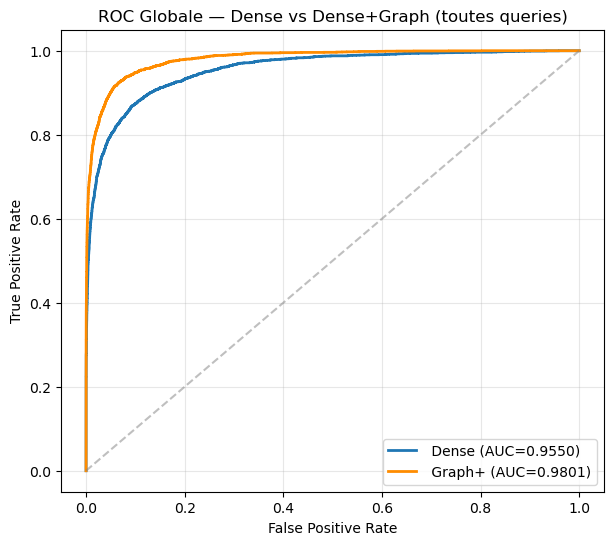


AUC globale Dense : 0.955036347826087
AUC globale Graph : 0.9800595362318841 ↑


In [12]:
# ============================================================
# === 8) Représentations améliorées via la structure du graphe ==
# ============================================================

import numpy as np
from tqdm import tqdm

print("\n============  8) GRAPH-ENHANCED EMBEDDINGS  ============\n")

# --------- Paramètres réglables ---------
alpha = 0.70    # poids vecteur original
beta  = 0.30    # poids des voisins du graphe
# (Tester 0.6/0.4, 0.8/0.2, 0.5/0.5 pour analyse)

# --------- Index mapping pour accès rapide ---------
node_to_idx = {doc_id:i for i,doc_id in enumerate(corpus.keys())}
idx_to_node = list(corpus.keys())
corpus_size = len(corpus_embeddings)

emb_dim = corpus_embeddings.shape[1]
enhanced_embeddings = np.zeros_like(corpus_embeddings)

print(f" Dimension des embeddings : {emb_dim} vecteurs × {corpus_size} docs")
print(" Génération des nouveaux vecteurs\n")

for i,doc_id in tqdm(enumerate(idx_to_node), total=corpus_size):

    base_vec = corpus_embeddings[i]   # vecteur dense original

    # Voisins = citations entrantes + sortantes
    neigh = list(G.predecessors(doc_id)) + list(G.successors(doc_id))
    neigh = [n for n in neigh if n in node_to_idx]  # filtre sécurité

    if len(neigh)==0:   # article isolé → on garde la représentation dense
        enhanced_embeddings[i] = base_vec
        continue

    neigh_vecs = np.array([corpus_embeddings[node_to_idx[n]] for n in neigh])
    mean_vec = np.mean(neigh_vecs, axis=0)

    # combinaison structurée
    enhanced_embeddings[i] = alpha*base_vec + beta*mean_vec

print("\n Graph-Enhanced Embeddings générés avec succès !")

# ============================================================
# === 8) Évaluation COMPLÈTE : Dense vs Graphe-Enhanced ========
# ============================================================
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
import numpy as np
import warnings


print("\n======================  TEST COMPARATIF MODELES ======================")
TOP_K_RETURN = 25
TOP_K_CHECK  = 5

# ----------------------- 1) Nouvel encodeur query =================-------

def encode_query_graph(qid):
    """ Encodage query = TEXTE + voisins structuraux comme pour les docs """
    q = model.encode(queries[qid]["text"], convert_to_numpy=True)

    refs  = queries[qid].get("metadata",{}).get("references",[])
    cites = queries[qid].get("metadata",{}).get("cited_by",[])
    neigh = refs + cites

    neigh_vecs = []
    for n in neigh:
        if n in node_to_idx:
            neigh_vecs.append(enhanced_embeddings[node_to_idx[n]])

    if len(neigh_vecs)==0: return q
    return 0.7*q + 0.3*np.mean(neigh_vecs,axis=0)    # mêmes poids que docs


# ----------------------- 2) Recherche DENSE PUIS GRAPHE -----------------------

def compare_search(qid, candidate_ids):
    q_text = queries[qid]["text"]

    # ===== modèle original =====
    cand_valid = [d for d in candidate_ids if d in corpus]
    emb_old = np.vstack([corpus_embeddings[node_to_idx[d]] for d in cand_valid])
    q_old   = model.encode([q_text], convert_to_numpy=True)
    scores_old = cosine_similarity(q_old, emb_old)[0]

    # ===== modèle graphe-aware =====
    emb_new = np.vstack([enhanced_embeddings[node_to_idx[d]] for d in cand_valid])
    q_new   = encode_query_graph(qid).reshape(1,-1)
    scores_new = cosine_similarity(q_new, emb_new)[0]

    labels = np.array([qrels_valid[qid].get(d,0) for d in cand_valid])

    # AUC uniquement si pos+neg présents
    auc_old = roc_auc_score(labels,scores_old) if len(set(labels))>1 else None
    auc_new = roc_auc_score(labels,scores_new) if len(set(labels))>1 else None

    # P@5 / R@5 / F1
    def metrics(scores):
        order = np.argsort(scores)[::-1][:TOP_K_CHECK]
        top_docs = [cand_valid[i] for i in order]
        tp = sum(qrels_valid[qid].get(d,0)==1 for d in top_docs)
        prec = tp/TOP_K_CHECK
        rec  = tp/5       # car dataset = 5 docs pertinents par query
        f1   = 2*prec*rec/(prec+rec) if prec+rec>0 else 0
        return prec,rec,f1

    P_old,R_old,F_old = metrics(scores_old)
    P_new,R_new,F_new = metrics(scores_new)

    return auc_old,auc_new,P_old,P_new,F_old,F_new


# ----------------------- 3) BOUCLE FINALE SUR VALID =================------

auc_o=[]; auc_n=[]
P_o=[];P_n=[]
F_o=[];F_n=[]

for qid, cands in qrels_valid.items():

    if qid not in queries: continue
    auc_old, auc_new, P_old,P_new,F_old,F_new = compare_search(qid,list(cands.keys()))

    if auc_old is not None and auc_new is not None:
        auc_o.append(auc_old); auc_n.append(auc_new)

    P_o.append(P_old); P_n.append(P_new)
    F_o.append(F_old); F_n.append(F_new)


print("\n======================  RÉSULTATS COMPARATIFS =======================")
print(f"Nombre de requêtes évaluées : {len(P_o)}\n")

print("➡ AUC moyen (dense)    :", np.mean(auc_o))
print("➡ AUC moyen (graph+)   :", np.mean(auc_n), "   +" if np.mean(auc_n)>np.mean(auc_o) else "   🔻")

print("\n➡ Precision@5 densité      :", np.mean(P_o))
print("➡ Precision@5 graph+       :", np.mean(P_n),  " +" if np.mean(P_n)>np.mean(P_o) else " 🔻")

print("\n➡ F1@5 densité             :", np.mean(F_o))
print("➡ F1@5 graph+              :", np.mean(F_n),  " +" if np.mean(F_n)>np.mean(F_o) else " 🔻")

print("\n=======================================================================")
print(" Tester différents poids (alpha/beta) pour optimiser encore.\n")

# ============================================================
# ===  ROC GLOBALE SUR TOUTES LES QUERIES =====================
# ============================================================
from sklearn.metrics import roc_curve, auc

all_scores_dense = []
all_labels_dense = []
all_scores_graph = []
all_labels_graph = []

for qid, cand_map in qrels_valid.items():
    
    if qid not in queries:
        continue
    
    candidate_ids = list(cand_map.keys())
    labels = np.array([cand_map.get(d,0) for d in candidate_ids])

    # --- DENSE ---
    emb_old = np.vstack([corpus_embeddings[node_to_idx[d]] for d in candidate_ids if d in corpus])
    q_old = model.encode([queries[qid]["text"]], convert_to_numpy=True)
    scores_old = cosine_similarity(q_old, emb_old)[0]

    all_scores_dense.extend(scores_old)
    all_labels_dense.extend(labels)

    # --- GRAPH+ ---
    emb_new = np.vstack([enhanced_embeddings[node_to_idx[d]] for d in candidate_ids if d in corpus])
    q_new = encode_query_graph(qid).reshape(1,-1)
    scores_new = cosine_similarity(q_new, emb_new)[0]

    all_scores_graph.extend(scores_new)
    all_labels_graph.extend(labels)

# ===== ROC aggregate =====
fpr_dense, tpr_dense, _ = roc_curve(all_labels_dense, all_scores_dense)
fpr_graph, tpr_graph, _ = roc_curve(all_labels_graph, all_scores_graph)

auc_dense = auc(fpr_dense, tpr_dense)
auc_graph = auc(fpr_graph, tpr_graph)

# ===== Plot =====
plt.figure(figsize=(7,6))
plt.plot(fpr_dense, tpr_dense, label=f" Dense (AUC={auc_dense:.4f})", lw=2)
plt.plot(fpr_graph, tpr_graph, label=f" Graph+ (AUC={auc_graph:.4f})", lw=2, color="darkorange")

plt.plot([0,1],[0,1],'--',color='grey',alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Globale — Dense vs Dense+Graph (toutes queries)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\nAUC globale Dense :",auc_dense)
print("AUC globale Graph :",auc_graph, "↑" if auc_graph>auc_dense else "↓")


In [13]:
# ============================================================
# === 9) Génération sample_submission_graph.csv ==============
# ============================================================


sample_path = base_path + r"\sample_submission.csv"
output_file = base_path + r"\sample_submission_graph.csv"
print("\n=== Chargement de sample_submission.csv ===")
df = pd.read_csv(sample_path, sep=",", dtype=str)

# mapping rapide doc_id → index dans enhanced_embeddings
doc_index = {doc_id: i for i, doc_id in enumerate(corpus.keys())}

# initialisation colonne score
df["score"] = 0.0

print("\n=== Calcul cosine_similarity sur embeddings GRAPHE ===")

# IMPORTANT : sort=False pour préserver l’ordre naturel d’apparition des queries
for qid, group_df in df.groupby("query-id", sort=False):

    # query absente → score = 0
    if qid not in queries:
        df.loc[group_df.index, "score"] = 0.0
        continue

    # encodage de la requête enrichie graphe
    q_vec = encode_query_graph(qid).reshape(1, -1)

    candidates = group_df["corpus-id"].tolist()
    scores = []

    for docid in candidates:
        idx = doc_index.get(docid)
        if idx is None:
            scores.append(-999.0)  # document absent → score très faible
        else:
            emb = enhanced_embeddings[idx].reshape(1, -1)
            scores.append(float(cosine_similarity(q_vec, emb)[0, 0]))

    # écriture STRICTEMENT aux bonnes lignes
    df.loc[group_df.index, "score"] = scores

# export final
df.to_csv(output_file, sep=",", index=False)

print("\n================= RESULTAT =================")
print(f" Nouveau fichier généré : {output_file}")
print(" Score = pure similarity graph-enhanced (aucun 0/1 top5).")
print("==========================================================")


=== Chargement de sample_submission.csv ===

=== Calcul cosine_similarity sur embeddings GRAPHE ===

================= RESULTAT =================
 Nouveau fichier généré : C:\Users\julie\OneDrive\Documents\Centrale Lyon 20252026\Data science\BE2\sample_submission_graph.csv
 Score = pure similarity graph-enhanced (aucun 0/1 top5).
